In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

before_path = "/Users/stern/Downloads/MATSim_homework/kelheim_origin/output/kelheim-origin-1pct/kelheim-v3.1-1pct.output_trips.csv.gz"
                        
after_path = "/Users/stern/Downloads/MATSim_homework/kelheim_ddlink_and_freespeed/output/output-kelheim-v3.1-1pct_final/kelheim-v3.1-1pct.output_trips.csv.gz"
                       

df_before = pd.read_csv(before_path, sep=";")
df_after = pd.read_csv(after_path, sep=";")

merged = pd.merge(
    df_before, df_after,
    on=["person", "trip_number"],
    suffixes=("_before", "_after")
)

def time_to_seconds(t):
    try:
        h, m, s = map(int, t.split(":"))
        return h * 3600 + m * 60 + s
    except:
        return None


merged["trav_time_before_sec"] = merged["trav_time_before"].apply(time_to_seconds)
merged["trav_time_after_sec"] = merged["trav_time_after"].apply(time_to_seconds)

merged["traveled_distance_before"] = pd.to_numeric(merged["traveled_distance_before"], errors="coerce")
merged["traveled_distance_after"] = pd.to_numeric(merged["traveled_distance_after"], errors="coerce")

time_reduced = (merged["trav_time_after_sec"] < merged["trav_time_before_sec"]).sum()
time_increased = (merged["trav_time_after_sec"] > merged["trav_time_before_sec"]).sum()
dist_reduced = (merged["traveled_distance_after"] < merged["traveled_distance_before"]).sum()
dist_increased = (merged["traveled_distance_after"] > merged["traveled_distance_before"]).sum()

mode_changes = merged[merged["main_mode_before"] != merged["main_mode_after"]]
mode_change_stats = mode_changes.groupby(["main_mode_before", "main_mode_after"]).size().reset_index(name="count")

changed_time_or_dist = merged[
    (merged["trav_time_before_sec"] != merged["trav_time_after_sec"]) |
    (merged["traveled_distance_before"] != merged["traveled_distance_after"])
]

same_mode_changes = changed_time_or_dist[
    changed_time_or_dist["main_mode_before"] == changed_time_or_dist["main_mode_after"]
]

same_mode_counts = same_mode_changes["main_mode_before"].value_counts().reset_index()
same_mode_counts.columns = ["main_mode", "count"]



print("\n🟩 main_mode changes(with changes of travel time and distance)")
print(same_mode_counts)

mode_before_counts = df_before["main_mode"].value_counts()
mode_after_counts = df_after["main_mode"].value_counts()

mode_df = pd.DataFrame({
    "increase": (mode_after_counts - mode_before_counts).clip(lower=0),
    "decrease": (mode_before_counts - mode_after_counts).clip(lower=0)
}).fillna(0).astype(int)


🟩 main_mode changes(with changes of travel time and distance)
  main_mode  count
0       car   2519
1      ride    607
2   freight     45
3        pt     13


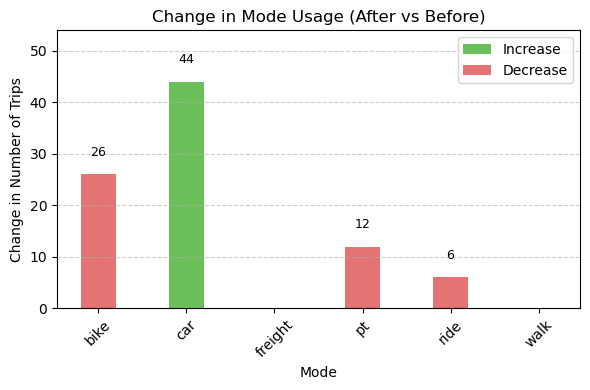

In [2]:
plt.figure(figsize=(6, 4))
bar_width = 0.4
x = range(len(mode_df))

bars1 = plt.bar(x, mode_df["increase"], width=bar_width, label="Increase", color="#6BBF59")
bars2 = plt.bar(x, mode_df["decrease"], width=bar_width, label="Decrease", color="#E57373")

plt.xticks(ticks=x, labels=mode_df.index, rotation=45)
plt.ylabel("Change in Number of Trips")
plt.xlabel("Mode")
plt.title("Change in Mode Usage (After vs Before)")
plt.legend()

plt.grid(axis="y", linestyle="--", alpha=0.6)

for bar in bars1:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 3, f"{int(height)}",
                 ha="center", va="bottom", fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 3, f"{int(height)}",
                 ha="center", va="bottom", fontsize=9)

plt.ylim(0, mode_df[["increase", "decrease"]].max().max() + 10)
plt.tight_layout()
plt.savefig("mode_change_comparison.png", dpi=300)
plt.show()

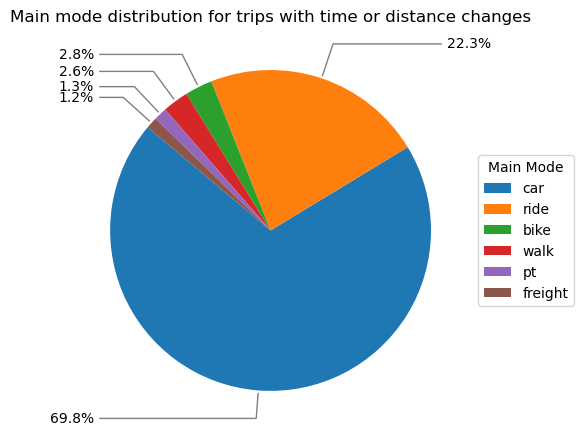

In [3]:
merged = pd.merge(
    df_before, df_after,
    on=["person", "trip_number"],
    suffixes=("_before", "_after")
)

# === Convert time to seconds ===
def time_to_seconds(t):
    try:
        h, m, s = map(int, t.split(":"))
        return h * 3600 + m * 60 + s
    except:
        return None

merged["trav_time_before_sec"] = merged["trav_time_before"].apply(time_to_seconds)
merged["trav_time_after_sec"] = merged["trav_time_after"].apply(time_to_seconds)
merged["traveled_distance_before"] = pd.to_numeric(merged["traveled_distance_before"], errors="coerce")
merged["traveled_distance_after"] = pd.to_numeric(merged["traveled_distance_after"], errors="coerce")

# === Filter: trips where time OR distance changed ===
changed_trips = merged[
    (merged["trav_time_before_sec"] != merged["trav_time_after_sec"]) |
    (merged["traveled_distance_before"] != merged["traveled_distance_after"])
]

# === Count main_mode_before distribution ===
mode_counts = changed_trips["main_mode_before"].value_counts()

# === Plot pie chart ===
fig, ax = plt.subplots(figsize=(5.5, 5.5))
total = mode_counts.sum()
labels = mode_counts.index
sizes = mode_counts.values

wedges, _ = ax.pie(sizes, startangle=140) 

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    percentage = f"{sizes[i]/total:.1%}"

    horizontalalignment = "left" if x >= 0 else "right"

    ax.annotate(
        percentage,
        xy=(x, y),
        xytext=(1.1* np.sign(x), 1.2 * y),
        horizontalalignment=horizontalalignment,
        fontsize=10,
        arrowprops=dict(arrowstyle="-", connectionstyle=f"angle,angleA=0,angleB={ang}", color="gray")
    )


ax.legend(wedges, labels, title="Main Mode", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Main mode distribution for trips with time or distance changes")
plt.tight_layout()
plt.savefig("mode_distribution.png", dpi=300, bbox_inches="tight")
plt.show()